## GBM Predict student performance in secondary education (high school).

This data approach student achievement in secondary education of two Portuguese schools. The data attributes include student grades, demographic, social and school related features) and it was collected by using school reports and questionnaires. Two datasets are provided regarding the performance in two distinct subjects: Mathematics (mat) and Portuguese language (por). Important note: the target attribute G3 has a strong correlation with attributes G2 and G1. This occurs because G3 is the final year grade (issued at the 3rd period), while G1 and G2 correspond to the 1st and 2nd period grades. It is more difficult to predict G3 without G2 and G1, but such prediction is much more useful (see paper source for more details).
https://archive.ics.uci.edu/ml/datasets/Student+Performance#

#### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

from collections import Counter
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from sklearn.cross_validation import train_test_split

/Users/Vera/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Loading data

In [2]:
students = pd.read_csv('student-mat.csv', sep=';')
students.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


#### Apply one-hot encoding for categorical variables

In [3]:
students_train = pd.get_dummies(students, columns=['school', 'sex', 'address','famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian'])

#### Encode binary features as 1/0

In [4]:
le = preprocessing.LabelEncoder()
def to_binary_columns(columns):
    for column in columns:
        le.fit(students_train[column])
        students_train[column] = le.transform(students_train[column])
        
binary_columns = ['schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
to_binary_columns(binary_columns)

#### Remove  G1, G2, G3 columns. The column G3 is to predict

In [5]:
del students_train['G1']
del students_train['G2']
del students_train['G3']

In [6]:
print(students_train.dtypes)

age                  int64
Medu                 int64
Fedu                 int64
traveltime           int64
studytime            int64
failures             int64
schoolsup            int64
famsup               int64
paid                 int64
activities           int64
nursery              int64
higher               int64
internet             int64
romantic             int64
famrel               int64
freetime             int64
goout                int64
Dalc                 int64
Walc                 int64
health               int64
absences             int64
school_GP            uint8
school_MS            uint8
sex_F                uint8
sex_M                uint8
address_R            uint8
address_U            uint8
famsize_GT3          uint8
famsize_LE3          uint8
Pstatus_A            uint8
Pstatus_T            uint8
Mjob_at_home         uint8
Mjob_health          uint8
Mjob_other           uint8
Mjob_services        uint8
Mjob_teacher         uint8
Fjob_at_home         uint8
F

#### Split the data in the ratio 90%: 10% for training and testing

In [7]:
train_X,test_X = train_test_split(students_train, test_size=0.1, random_state=42)
train_y,test_y = train_test_split(students['G3'], test_size=0.1, random_state=42)

#### Training XGBRegressor for 200 trees with a maximum depth of 4, learning rate 0.05

In [8]:
xgb_model = xgb.XGBRegressor(max_depth=4, learning_rate=0.05, n_estimators=200, seed=42).fit(train_X, train_y)

#### Calculate the average prediction error (MAE) using a test data .

In [9]:
predicted_test =  xgb_model.predict(test_X);
mae = mean_absolute_error(test_y, predicted_test)
print('The average prediction error (MAE):', mae)

The average prediction error (MAE): 3.25385516882


#### Construct a residual plot (difference between predicted and real value)

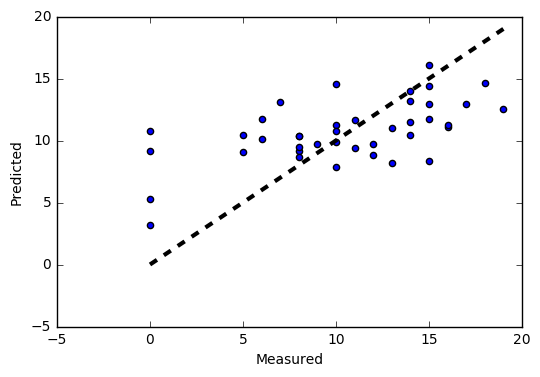

In [10]:
fig, ax = plt.subplots()
ax.scatter(test_y, predicted_test)
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw=3)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

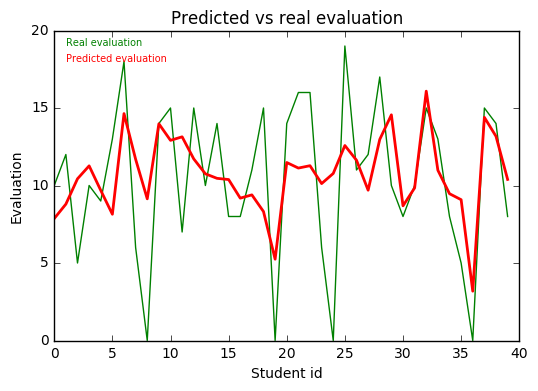

In [11]:
plt.plot(test_y.values, color="green", linewidth=1)
plt.plot(predicted_test, color="red", linewidth=2)
plt.xlabel('Student id')
plt.ylabel('Evaluation')
plt.title('Predicted vs real evaluation')
plt.text(1,19,'Real evaluation', color="green", fontsize=7)
plt.text(1,18,'Predicted evaluation', color="red", fontsize=7)
plt.show()

#### Using a trained model obtain numerical importance of each feature and construct a histogram

In [12]:
feature_importance = xgb_model.booster().get_fscore()

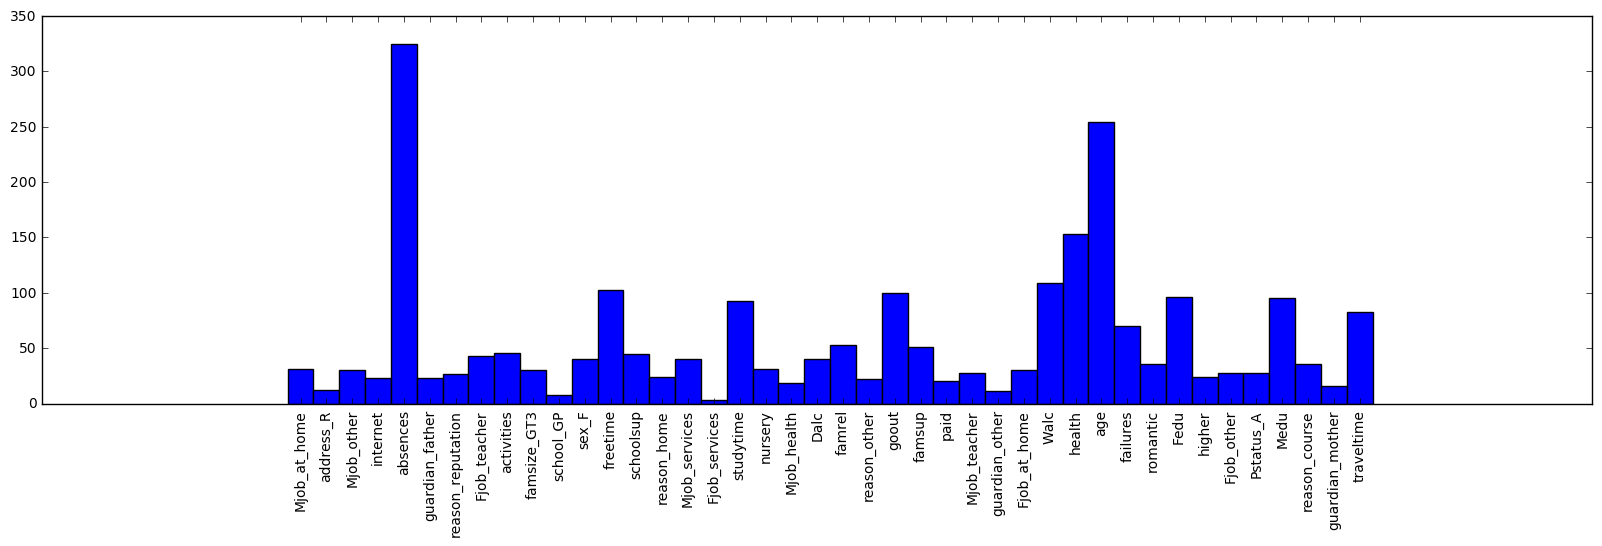

In [13]:
X = np.arange(len(feature_importance))
plt.figure(figsize=(20,5))
plt.bar(X, feature_importance.values(), align='center', width=1)
plt.xticks(X, feature_importance.keys(), rotation=90)
plt.show()

#### Find the 5 most important features

In [14]:
Counter(feature_importance).most_common(5)

[('absences', 325),
 ('age', 254),
 ('health', 153),
 ('Walc', 109),
 ('freetime', 103)]

#### Let's change the number of trees in models ranging from 10 to 300 and find MAE in the test sample.

In [15]:
def train_models(trees, maes):
    for tree in trees:
        model = xgb.XGBRegressor(max_depth=4, learning_rate=0.05, n_estimators=tree, seed=42).fit(train_X, train_y)
        mae = mean_absolute_error(test_y, model.predict(test_X))
        maes.append(mae)
        print('number of trees:', tree, '| the average prediction error:', mae)
        print('----------------------------------------------------------')

In [16]:
trees = np.arange(10, 301, 5)
maes = []
train_models(trees, maes)

number of trees: 10 | the average prediction error: 6.60093344152
----------------------------------------------------------
number of trees: 15 | the average prediction error: 5.50010842681
----------------------------------------------------------
number of trees: 20 | the average prediction error: 4.78385347128
----------------------------------------------------------
number of trees: 25 | the average prediction error: 4.29256833792
----------------------------------------------------------
number of trees: 30 | the average prediction error: 4.02395173907
----------------------------------------------------------
number of trees: 35 | the average prediction error: 3.85046544671
----------------------------------------------------------
number of trees: 40 | the average prediction error: 3.730924505
----------------------------------------------------------
number of trees: 45 | the average prediction error: 3.60845790505
----------------------------------------------------------
nu

#### Construct a graph of the MAE depends on the number of trees

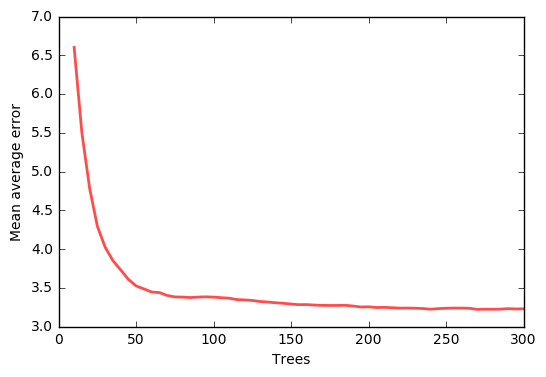

In [17]:
plt.plot(trees,maes, color="red", alpha=0.7, linewidth=2.0)
plt.ylabel('Mean average error')
plt.xlabel('Trees')
plt.show()